In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
import os
import glob
import random
import torch.nn as nn
import torch.utils.data as data
import scipy.misc as S

from torchvision import datasets,models
from torchvision.transforms import functional as F
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict,deque
import datetime
import math
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
import cv2
from typing_extensions import Concatenate
from skimage.transform import resize
from collections import Counter

# bbox and mask predictors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
dataset_path= "/kaggle/input/car-segmentation/car-segmentation/"
#contains folders images and masks which in turn contain pair of png files


In [4]:

class CarDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, index):
        #loading image and masks
        img_path = os.path.join(self.root, "images", self.images[index])
        mask_path = os.path.join(self.root, "masks", self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        part_ids = np.unique(mask)
        #Removing background
        part_ids = part_ids[1:] #0

        #splitting into binary masks
        masks = mask == part_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_parts = len(part_ids)
        boxes = []
        for i in range(num_parts):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = []
        for part_id in part_ids: 
          labels.append(part_id)
        labels= torch.tensor((labels), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_parts,), dtype=torch.int64)
        

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        
        if self.transforms is not None:
           img, target = self.transforms(image, target)

        return img, target

    def __len__(self):
        return len(self.images)    

In [5]:
def SegmentationModel(num_classes):
    #loading instance seg pretrained model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replacing pretrained head with new
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

    #now doing the same for input features for mask
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer=512
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

In [6]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 585196, done.
remote: Counting objects: 100% (32982/32982), done.
remote: Compressing objects: 100% (1957/1957), done.
remote: Total 585196 (delta 30894), reused 32835 (delta 30791), pack-reused 552214 (from 1)
Receiving objects: 100% (585196/585196), 1.09 GiB | 44.38 MiB/s, done.
Resolving deltas: 100% (546987/546987), done.
/kaggle/working/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against P

In [7]:
!pip install pycocotools
from engine import train_one_epoch, evaluate
import utils
import transforms as T

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.3/403.3 kB 10.2 MB/s eta 0:00:0000:01


In [8]:
def apply_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:

train_dataset = CarDataset(dataset_path, apply_transform(train=True))
val_dataset = CarDataset(dataset_path, apply_transform(train=False))

In [10]:
# splitting the dataset on train and val with constant seed
torch.manual_seed(42)

idxs = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, idxs[:-10])
val_dataset = torch.utils.data.Subset(train_dataset,idxs[-10:])

In [11]:
train_data_loader = DataLoader(train_dataset,batch_size=4, shuffle=True,num_workers=4, collate_fn=utils.collate_fn)

val_data_loader = DataLoader(val_dataset,batch_size=2, shuffle=False, collate_fn=utils.collate_fn)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
num_classes =5
model = SegmentationModel(num_classes)
model.to(device)
optimizer= torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


  0%|          | 0.00/177M [00:00<?, ?B/s]

In [13]:
for epoch in range(90):
  train_one_epoch(model, optimizer, train_data_loader,device,epoch,print_freq=10)
  optimizer.step()
  evaluate(model,val_data_loader,device=device)

Epoch: [0]  [ 0/51]  eta: 0:05:16  lr: 0.000021  loss: 4.0543 (4.0543)  loss_classifier: 1.9177 (1.9177)  loss_box_reg: 0.1747 (0.1747)  loss_mask: 1.3424 (1.3424)  loss_objectness: 0.3729 (0.3729)  loss_rpn_box_reg: 0.2466 (0.2466)  time: 6.2120  data: 0.4362  max mem: 8082
Epoch: [0]  [10/51]  eta: 0:00:58  lr: 0.000221  loss: 1.7914 (2.4122)  loss_classifier: 0.4544 (0.8714)  loss_box_reg: 0.2405 (0.2412)  loss_mask: 0.7500 (0.8526)  loss_objectness: 0.0487 (0.1899)  loss_rpn_box_reg: 0.2474 (0.2570)  time: 1.4149  data: 0.0723  max mem: 8841
Epoch: [0]  [20/51]  eta: 0:00:37  lr: 0.000421  loss: 1.0635 (1.7010)  loss_classifier: 0.2537 (0.5560)  loss_box_reg: 0.2502 (0.2527)  loss_mask: 0.3622 (0.5675)  loss_objectness: 0.0274 (0.1104)  loss_rpn_box_reg: 0.2035 (0.2143)  time: 0.9458  data: 0.0374  max mem: 9282
Epoch: [0]  [30/51]  eta: 0:00:23  lr: 0.000620  loss: 0.7108 (1.3431)  loss_classifier: 0.1287 (0.4050)  loss_box_reg: 0.2058 (0.2299)  loss_mask: 0.1873 (0.4395)  loss_ob

In [14]:
torch.save(model, 'mask-rcnn-car_seg.pt')


In [15]:
model.eval()
CLASS_NAMES = ['__background__', 'car','wheel','lights','window']
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [19]:
def color_mask(mask):
    # defining 5 colors for segmentation
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,5)]
    coloured_mask = np.stack([r, g, b], axis=2) #stacking along channel axis
    return coloured_mask

def predict(img_path, confidence):
    
    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()

    img = convert_tensor(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def visualize_predictions(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

    masks, boxes, pred_cls = predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = color_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.6, 0)
      boxes[i][0] = [int(i) for i in boxes[i][0]]
      boxes[i][1] = [int(i) for i in boxes[i][1]]
      
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [21]:
!wget https://media.colomio.com/how-to-draw/car-drawing-kids-6.jpg

--2024-11-13 06:32:00--  https://media.colomio.com/how-to-draw/car-drawing-kids-6.jpg
Resolving media.colomio.com (media.colomio.com)... 104.18.42.227, 172.64.145.29, 2606:4700:4400::6812:2ae3, ...
Connecting to media.colomio.com (media.colomio.com)|104.18.42.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71970 (70K) [image/jpeg]
Saving to: ‘car-drawing-kids-6.jpg’

car-drawing-kids-6. 100%[===================>]  70.28K  --.-KB/s    in 0.01s   

2024-11-13 06:32:00 (4.72 MB/s) - ‘car-drawing-kids-6.jpg’ saved [71970/71970]



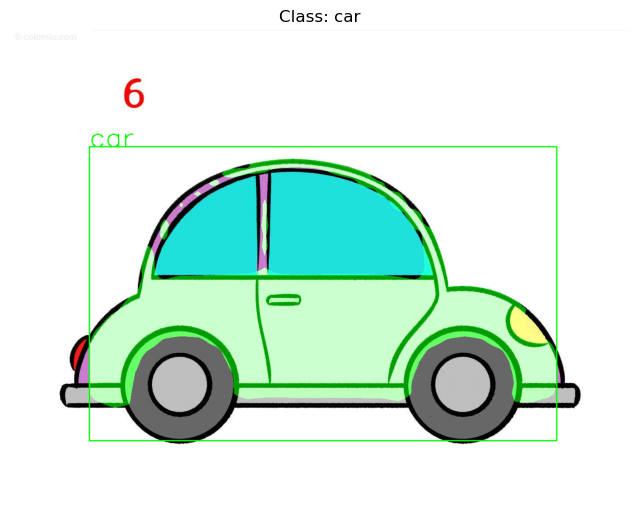

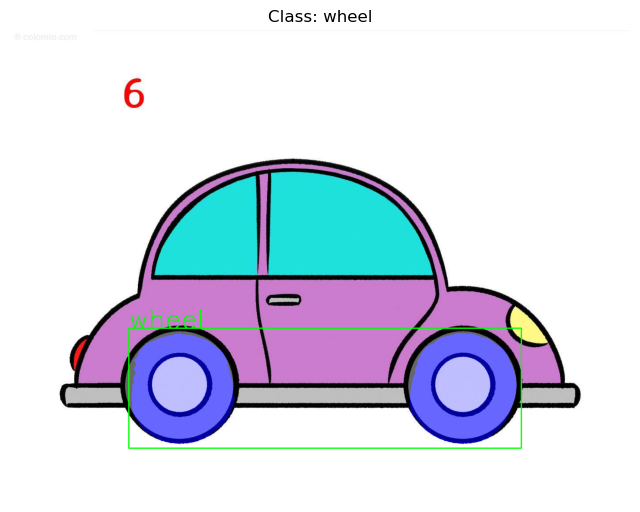

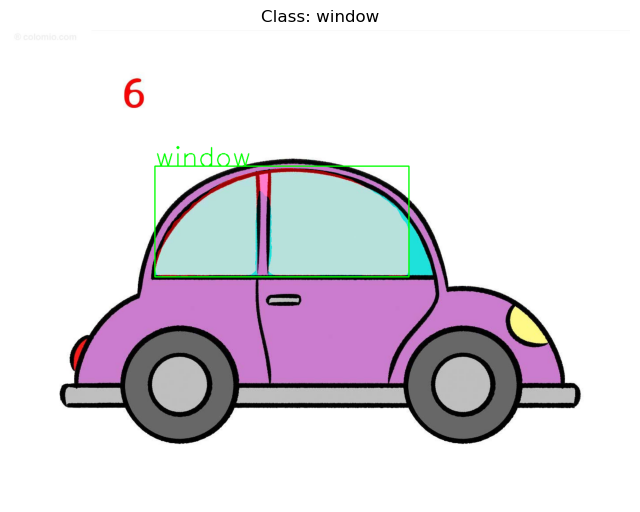

Tất cả các ảnh từng lớp đã được lưu vào thư mục: class_images


In [27]:
import os
import matplotlib.pyplot as plt

def save_and_show_class_images(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2, output_folder="class_images"):
    # Tạo thư mục lưu ảnh nếu chưa tồn tại
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    masks, boxes, pred_cls = predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for i in range(len(masks)):
        rgb_mask = color_mask(masks[i])
        
        # Tạo bản sao ảnh gốc để thêm mask và box chỉ cho từng lớp (class)
        img_copy = img.copy()
        img_copy = cv2.addWeighted(img_copy, 1, rgb_mask, 0.6, 0)

        # Vẽ bounding box và tên lớp
        boxes[i][0] = [int(coord) for coord in boxes[i][0]]
        boxes[i][1] = [int(coord) for coord in boxes[i][1]]
        cv2.rectangle(img_copy, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img_copy, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

        # Lưu ảnh cho từng lớp (class)
        class_image_path = os.path.join(output_folder, f"{pred_cls[i]}_{i}.png")
        cv2.imwrite(class_image_path, cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR))
        
        # Hiển thị ảnh từng lớp
        plt.figure(figsize=(8, 8))
        plt.imshow(img_copy)
        plt.title(f"Class: {pred_cls[i]}")
        plt.axis('off')
        plt.show()

    print(f"Tất cả các ảnh từng lớp đã được lưu vào thư mục: {output_folder}")

# Gọi hàm để lưu và hiển thị ảnh từng lớp
save_and_show_class_images('/kaggle/working/vision/car-drawing-kids-6.jpg', confidence=0.5)


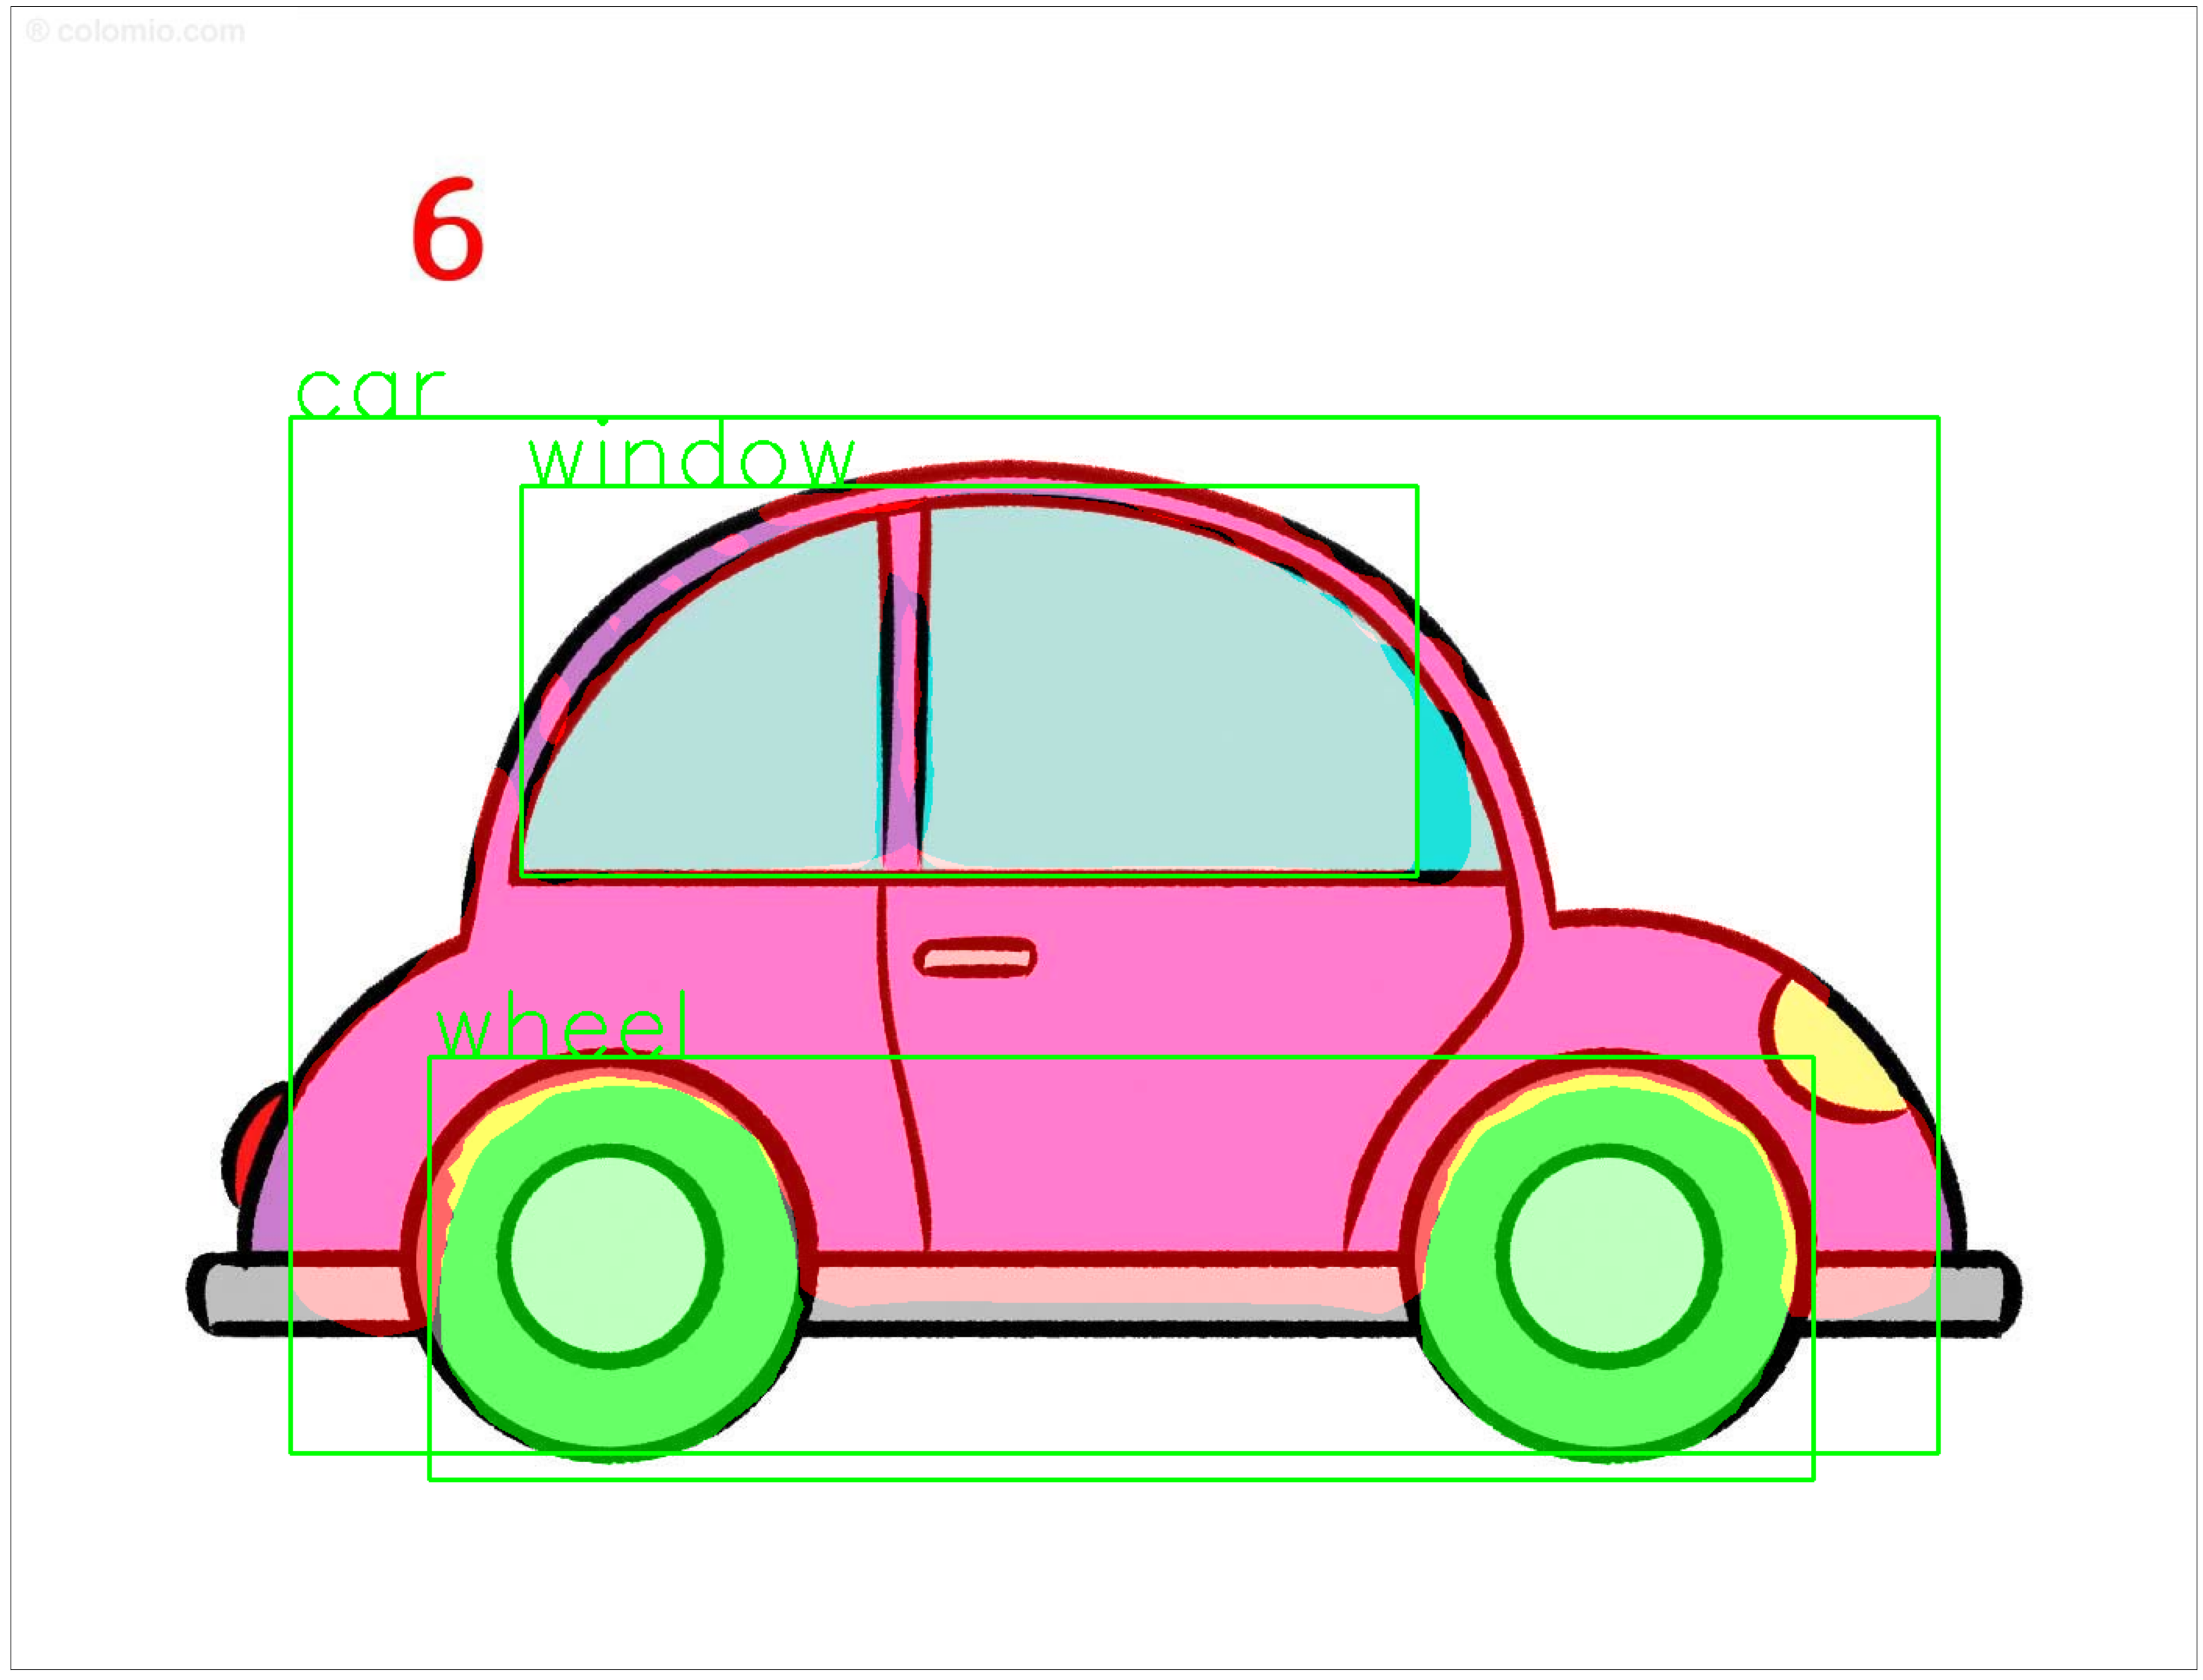

In [24]:
visualize_predictions('/kaggle/working/vision/car-drawing-kids-6.jpg', confidence=0.5)
